In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle_Data/P2P lending/

/content/gdrive/My Drive/Kaggle_Data/P2P lending


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data =  pd.read_csv("data_3.csv",index_col=False)

In [ ]:
pd.set_option('display.max_columns', None)
data.head(3)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,hardship_flag,disbursement_method,debt_settlement_flag,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:ND,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,Non-Default_Default,home_ownership:RENT_OTHER_NONE,home_ownership:MORTGAGE_ANY,addr_state:IA_OK_AR_AL_LA_HI_MS,addr_state:SD_NY_NM_NV,addr_state:FL_NC,addr_state:MD_KY_NJ_IN,addr_state:VA_PA_MO_TN,addr_state:MN_CA,addr_state:NE_AZ_AK_MI,addr_state:MA_UT_OH,addr_state:DE_GA_WI_WY,addr_state:MT_RI_IL,addr_state:KS_CO_CT_WA_ND_SC,addr_state:NH_WV_OR_DC,addr_state:ID_VT_ME,sub_grade:G4_G3,sub_grade:F5_F4,sub_grade:G5_G2_F2_G1_F3,sub_grade:E3_E4_E5_E2_E1,sub_grade:D4_D5,sub_grade:D3_D2_D1,purpose:SB_RE_M,purpose:med_oth_wed_hou
0,84574055,8000.0,8000.0,8000.0,36 months,15.59,279.64,C,C5,Produce Clerk,10+ years,RENT,36000.0,Source Verified,Jul-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,other,Other,107xx,NY,12.50,1.0,Mar-2000,670.0,674.0,0.0,22.0,NaN,4.0,0.0,1319.0,48.9,7.0,f,0.0,0.0,2556.26,2556.26,1089.08,581.83,0.0,885.35,159.3630,Jan-2017,279.64,Jul-2017,504.0,500.0,0.0,1.0,Individual,0.0,0.0,20549.0,2700.0,N,Cash,N,10,36.0,2000-03-01,213.0,2016-07-01,17.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

**Spliting the data**

In [ ]:
from sklearn.model_selection import train_test_split as tts
data_inputs_train,data_inputs_test,data_targets_train,data_targets_test=tts(data.drop('Non-Default_Default',axis=1),data['Non-Default_Default'],test_size=0.2, random_state=42)


In [ ]:
data_inputs_train.shape

(465323, 216)

In [ ]:
data_inputs_test.shape

(116331, 216)

In [ ]:
input_pr=data_inputs_train
target_pr=data_targets_train

### Woe and IV function

In [ ]:
def woe_dis(df,discrete_variable_name,good_default_variable_df):
  df=pd.concat([df[discrete_variable_name],good_default_variable_df],axis=1)
  df=pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
  df=df.iloc[:,[0,1,3]]
  df.columns=[df.columns.values[0],'n_obs','prop_good']
  df['prop_n_obs']=df['n_obs']/df['n_obs'].sum()
  df['n_good']=df['prop_good']*df['n_obs']
  df['n_default']=(1-df['prop_good'])*df['n_obs']
  df['prop_n_good']=df['n_good']/df['n_good'].sum()
  df['prop_n_default']=df['n_default']/df['n_default'].sum()
  df['WoE']=np.log(df['prop_n_good']/df['prop_n_default'])
  df=df.sort_values(['WoE'])
  df=df.reset_index(drop=True)
  df['diff_prop_good']=df['prop_good'].diff().abs()
  df['diif_WoE']=df['WoE'].diff().abs()
  df['IV']=(df['prop_n_good']-df['prop_n_default'])*df['WoE']
  df['IV']=df['IV'].sum()
  return df

### WoE plot function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def plot_by_woe(df_WoE, rotation_of_x_labels=0):
	x=np.array(df_WoE.iloc[:,0].apply(str))
	y=df_WoE['WoE']
	plt.figure(figsize = (18,6))
	plt.plot(x,y,marker='o',linestyle = '--',color='k')
	plt.xlabel(df_WoE.columns[0])
	plt.ylabel('Weight of Evidence')
	plt.title(str('Weight of Evidence by '+df_WoE.columns[0]))
	plt.xticks(rotation =rotation_of_x_labels)

### modifying WoE function

In [ ]:
def woe_con(df,discrete_variable_name,good_default_variable_df):
      df=pd.concat([df[discrete_variable_name],good_default_variable_df],axis=1)
      df=pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
      df=df.iloc[:,[0,1,3]]
      df.columns=[df.columns.values[0],'n_obs','prop_good']
      df['prop_n_obs']=df['n_obs']/df['n_obs'].sum()
      df['n_good']=df['prop_good']*df['n_obs']
      df['n_default']=(1-df['prop_good'])*df['n_obs']
      df['prop_n_good']=df['n_good']/df['n_good'].sum()
      df['prop_n_default']=df['n_default']/df['n_default'].sum()
      df['WoE']=np.log(df['prop_n_good']/df['prop_n_default'])
      #df=df.sort_values(['WoE'])
      #df=df.reset_index(drop=True)
      df['diff_prop_good']=df['prop_good'].diff().abs()
      df['diif_WoE']=df['WoE'].diff().abs()
      df['IV']=(df['prop_n_good']-df['prop_n_default'])*df['WoE']
      df['IV']=df['IV'].sum()
      return df

# Preprocessing continues variable

## term of the load preprocessing 
The number of payments on the loan. Values are in months and can be either 36 or 60.

In [ ]:
data['term_int'].value_counts()

36.0    388154
60.0    193500
Name: term_int, dtype: int64

In [ ]:
g=woe_con(input_pr,'term_int',target_pr)
g

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,36.0,310709,0.545024,0.667728,169344.0,141365.0,0.72823,0.607288,0.181614,NaN,NaN,0.066486
1,60.0,154614,0.408747,0.332272,63198.0,91416.0,0.27177,0.392712,-0.368121,0.136278,0.549735,0.066486


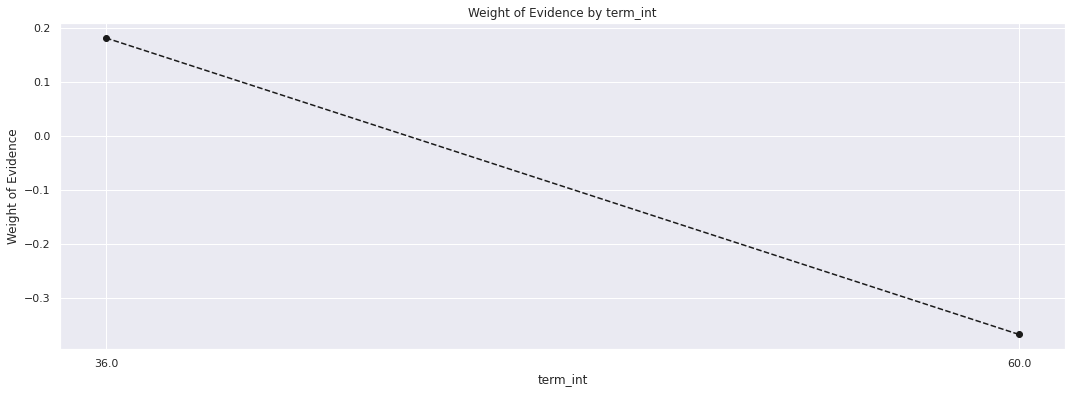

In [ ]:
plot_by_woe(g)

In [ ]:
data['term:36']=np.where(data['term_int']==36,1,0)
data['term:60']=np.where(data['term_int']==60,1,0)

## **employement length**
**Employment length in years.**

In [ ]:
data['emp_length_int'].unique()

array([10,  5,  0,  3,  2,  6,  4,  9,  8,  7,  1])

In [ ]:
g=woe_con(input_pr,'emp_length_int',target_pr)
g

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,0,71957,0.473283,0.154639,34056.0,37901.0,0.146451,0.162818,-0.105944,NaN,NaN,0.004643
1,1,30804,0.488346,0.066199,15043.0,15761.0,0.064689,0.067707,-0.045599,0.015063,0.060346,0.004643
2,2,42177,0.501766,0.090640,21163.0,21014.0,0.091007,0.090274,0.008093,0.013421,0.053691,0.004643
3,3,37284,0.497532,0.080125,18550.0,18734.0,0.079771,0.080479,-0.008843,0.004234,0.016936,0.004643
4,4,27978,0.504146,0.060126,14105.0,13873.0,0.060656,0.059597,0.017612,0.006614,0.026455,0.004643
5,5,28610,0.498951,0.061484,14275.0,14335.0,0.061387,0.061581,-0.003167,0.005195,0.020779,0.004643
6,6,21259,0.505574,0.045687,10748.0,10511.0,0.046220,0.045154,0.023325,0.006623,0.026492,0.004643
7,7,19442,0.488941,0.041782,9506.0,9936.0,0.040879,0.042684,-0.043214,0.016633,0.066539,0.004643
8,8,19612,0.475117,0.042147,9318.0,10294.0,0.040070,0.044222,-0.098586,0.013824,0.055372,0.004643
9,9,16638,0.483051,0.035756,8037.0,8601.0,0.034561,0.036949,-0.066795,0.007934,0.031791,0.004643


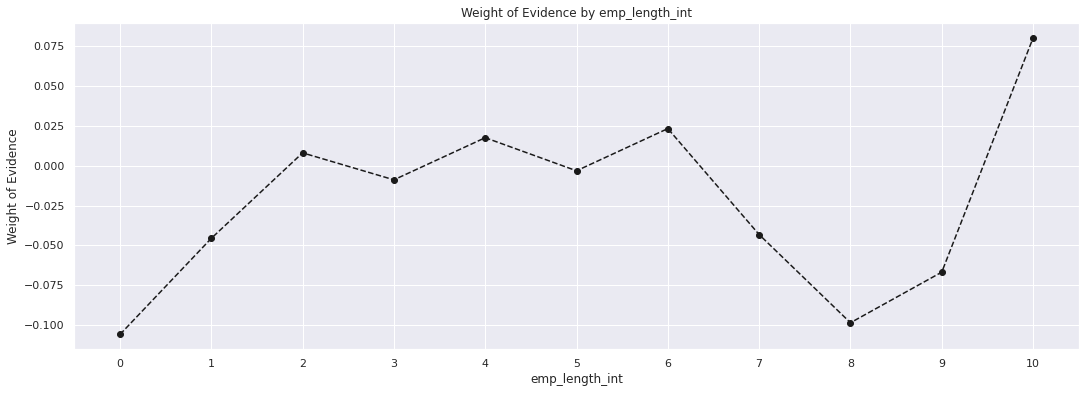

In [ ]:
plot_by_woe(g)

In [ ]:
data['emp_length:0']=np.where(data['emp_length_int'].isin([0]),1,0)
data['emp_length:1']=np.where(data['emp_length_int'].isin([1]),1,0)
data['emp_length:2']=np.where(data['emp_length_int'].isin([2]),1,0)
data['emp_length:3']=np.where(data['emp_length_int'].isin([3]),1,0)
data['emp_length:4-6']=np.where(data['emp_length_int'].isin(range(4,7)),1,0)
data['emp_length:7-9']=np.where(data['emp_length_int'].isin(range(7,10)),1,0)
data['emp_length:10']=np.where(data['emp_length_int'].isin([10]),1,0)

## **issue_d**
**Date the loan was issued**

In [ ]:
data['mths_since_issue_d'].max()

126.0

applying **Fine classing** by using padas cut function

In [ ]:
input_pr['mths_since_issue_d_factor']=pd.cut(input_pr['mths_since_issue_d'],50)


In [ ]:
input_pr['mths_since_issue_d_factor']

285640     (42.84, 45.36]
89702     (123.48, 126.0]
368775       (5.04, 7.56]
541137      (7.56, 10.08]
502566     (-0.126, 2.52]
               ...       
110268     (17.64, 20.16]
259178      (37.8, 40.32]
365838    (123.48, 126.0]
131932     (27.72, 30.24]
121958      (35.28, 37.8]
Name: mths_since_issue_d_factor, Length: 465323, dtype: category
Categories (50, interval[float64]): [(-0.126, 2.52] < (2.52, 5.04] < (5.04, 7.56] < (7.56, 10.08] < ... <
                                     (115.92, 118.44] < (118.44, 120.96] < (120.96, 123.48] <
                                     (123.48, 126.0]]

Applying WoE function

In [ ]:
g=woe_con(input_pr,'mths_since_issue_d_factor',target_pr)
g

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.126, 2.52]",20817,0.625498,0.044737,13021.0,7796.0,0.055994,0.033491,0.513980,NaN,NaN,0.376881
1,"(2.52, 5.04]",23455,0.559454,0.050406,13122.0,10333.0,0.056429,0.044389,0.239975,0.066044,0.274005,0.376881
2,"(5.04, 7.56]",14874,0.526019,0.031965,7824.0,7050.0,0.033646,0.030286,0.105196,0.033436,0.134779,0.376881
3,"(7.56, 10.08]",18958,0.509917,0.040742,9667.0,9291.0,0.041571,0.039913,0.040699,0.016102,0.064496,0.376881
4,"(10.08, 12.6]",14660,0.475102,0.031505,6965.0,7695.0,0.029952,0.033057,-0.098646,0.034814,0.139345,0.376881
5,"(12.6, 15.12]",20921,0.454902,0.044960,9517.0,11404.0,0.040926,0.048990,-0.179857,0.020201,0.081211,0.376881
6,"(15.12, 17.64]",16937,0.411053,0.036398,6962.0,9975.0,0.029939,0.042851,-0.358588,0.043849,0.178731,0.376881
7,"(17.64, 20.16]",23065,0.415998,0.049568,9595.0,13470.0,0.041261,0.057866,-0.338196,0.004946,0.020392,0.376881
8,"(20.16, 22.68]",24563,0.406546,0.052787,9986.0,14577.0,0.042943,0.062621,-0.377234,0.009452,0.039038,0.376881
9,"(22.68, 25.2]",27605,0.400145,0.059324,11046.0,16559.0,0.047501,0.071136,-0.403834,0.006402,0.026601,0.376881


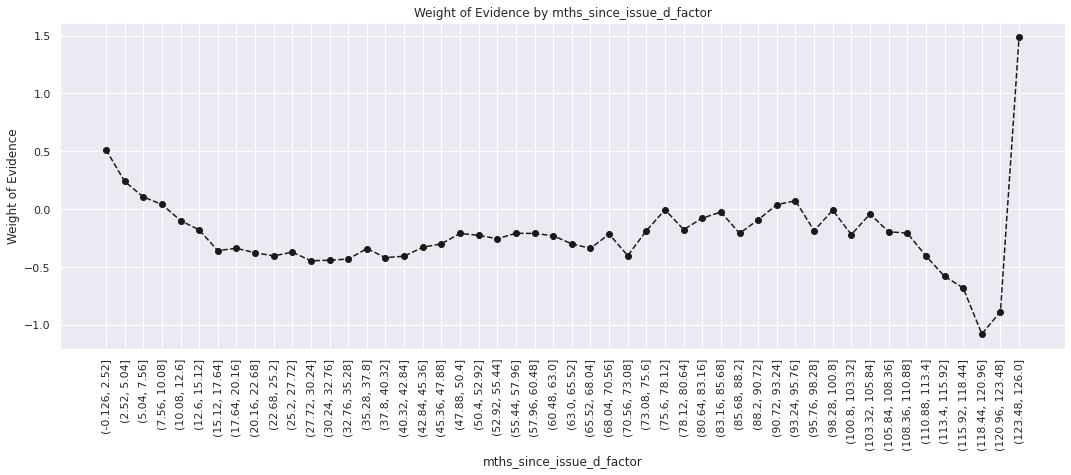

In [ ]:
plot_by_woe(g,90)

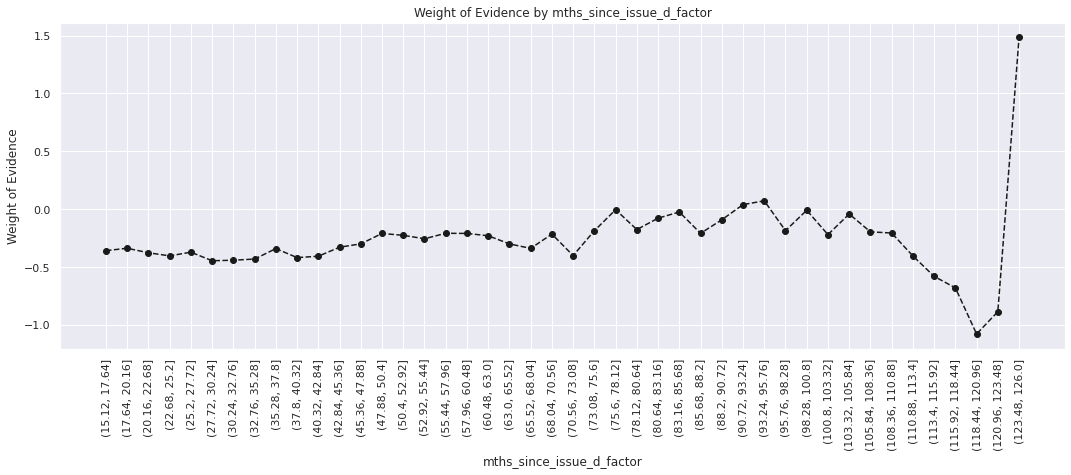

In [ ]:
plot_by_woe(g.iloc[6:,:],90)

In [ ]:
data['mths_since_issue_d:<3']=np.where(data['mths_since_issue_d'].isin(range(0,4)),1,0)
data['mths_since_issue_d:63-123']=np.where(data['mths_since_issue_d'].isin(range(63,124)),1,0)
data['mths_since_issue_d:2-10']=np.where(data['mths_since_issue_d'].isin(range(2,11)),1,0)
data['mths_since_issue_d:10-13']=np.where(data['mths_since_issue_d'].isin(range(10,14)),1,0)
data['mths_since_issue_d:13-23']=np.where(data['mths_since_issue_d'].isin(range(13,24)),1,0)
data['mths_since_issue_d:23-46']=np.where(data['mths_since_issue_d'].isin(range(23,47)),1,0)
data['mths_since_issue_d:45-63']=np.where(data['mths_since_issue_d'].isin(range(45,64)),1,0)
data['mths_since_issue_d:>123']=np.where(data['mths_since_issue_d'].isin(range(123,127)),1,0)


## **int_rate**
**Interest Rate on the loan**

In [ ]:
data['int_rate'].sample(5)

73583     17.47
304621    15.59
99903     11.99
136503    12.99
132864    16.02
Name: int_rate, dtype: float64

In [ ]:
data['int_rate'].max()

30.99

In [ ]:
input_pr['int_rate_factor']=pd.cut(input_pr['int_rate'],50)


In [ ]:
input_pr['int_rate_factor']

285640     (18.15, 18.664]
89702     (15.582, 16.096]
368775    (18.664, 19.177]
541137     (10.96, 11.473]
502566      (11.987, 12.5]
                ...       
110268      (11.987, 12.5]
259178      (11.987, 12.5]
365838      (6.851, 7.364]
131932     (17.636, 18.15]
121958     (17.636, 18.15]
Name: int_rate_factor, Length: 465323, dtype: category
Categories (50, interval[float64]): [(5.284, 5.824] < (5.824, 6.337] < (6.337, 6.851] <
                                     (6.851, 7.364] ... (28.936, 29.449] < (29.449, 29.963] <
                                     (29.963, 30.476] < (30.476, 30.99]]

In [ ]:
g=woe_con(input_pr,'int_rate_factor',target_pr)
g

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(5.284, 5.824]",7550,0.871656,0.016225,6581.0,969.0,0.028300,0.004163,1.916705,NaN,NaN,0.468457
1,"(5.824, 6.337]",6433,0.891808,0.013825,5737.0,696.0,0.024671,0.002990,2.110369,0.020152,0.193665,0.468457
2,"(6.337, 6.851]",6999,0.847550,0.015041,5932.0,1067.0,0.025509,0.004584,1.716538,0.044258,0.393832,0.468457
3,"(6.851, 7.364]",13457,0.799584,0.028920,10760.0,2697.0,0.046271,0.011586,1.384723,0.047966,0.331815,0.468457
4,"(7.364, 7.878]",7803,0.781751,0.016769,6100.0,1703.0,0.026232,0.007316,1.276925,0.017833,0.107798,0.468457
5,"(7.878, 8.392]",22470,0.681709,0.048289,15318.0,7152.0,0.065872,0.030724,0.762664,0.100042,0.514261,0.468457
6,"(8.392, 8.905]",5692,0.731553,0.012232,4164.0,1528.0,0.017906,0.006564,1.003544,0.049844,0.240880,0.468457
7,"(8.905, 9.419]",8626,0.568398,0.018538,4903.0,3723.0,0.021084,0.015994,0.276345,0.163155,0.727199,0.468457
8,"(9.419, 9.932]",16107,0.680201,0.034615,10956.0,5151.0,0.047114,0.022128,0.755724,0.111803,0.479379,0.468457
9,"(9.932, 10.446]",12939,0.665430,0.027806,8610.0,4329.0,0.037026,0.018597,0.688615,0.014771,0.067109,0.468457


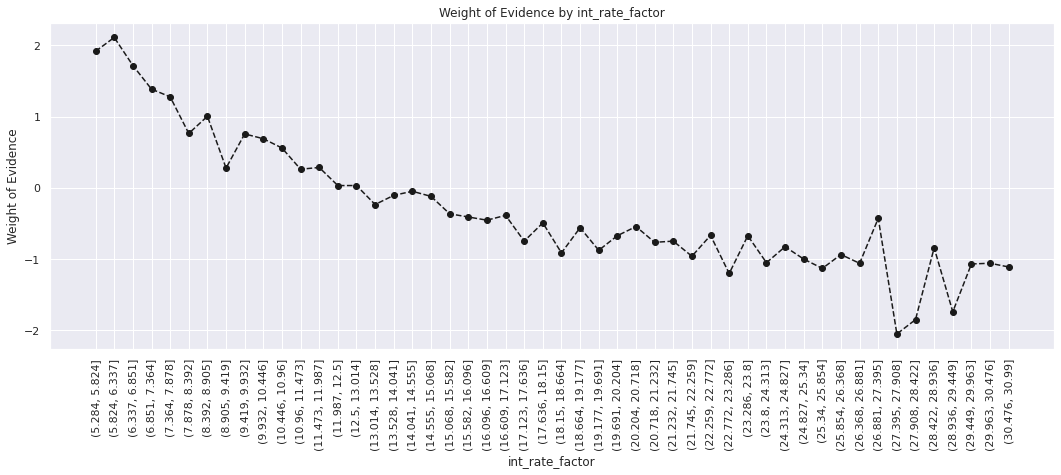

In [ ]:
plot_by_woe(g,90)

In [ ]:
(data['int_rate']>9.419)&(data['int_rate']<=17.123)

0          True
1          True
2          True
3          True
4          True
          ...  
581649    False
581650     True
581651     True
581652     True
581653    False
Name: int_rate, Length: 581654, dtype: bool

In [ ]:
data['int_rate:<9.419']=np.where((data['int_rate']<=9.419),1,0)
data['int_rate:9.419-12.5']=np.where((data['int_rate']>9.419)&(data['int_rate']<=12.5),1,0)
data['int_rate:12.5-15.068']=np.where((data['int_rate']>12.5)&(data['int_rate']<=15.068),1,0)
data['int_rate:15.068-20.204']=np.where((data['int_rate']>15.068)&(data['int_rate']<=20.204),1,0)
data['int_rate:>20.204']=np.where((data['int_rate']>20.204),1,0)

## **funded_amnt**
**The total amount committed to that loan at that point in time.**

In [ ]:
data['funded_amnt'].sample(5)

522251    24000.0
516420    25000.0
178376    12300.0
323108    25000.0
25772     10000.0
Name: funded_amnt, dtype: float64

In [ ]:
data['funded_amnt'].max()

40000.0

In [ ]:
input_pr['funded_amnt_factor']=pd.cut(input_pr['funded_amnt'],50)
data['funded_amnt_factor']=pd.cut(data['funded_amnt'],50)

In [ ]:
g=woe_con(input_pr,'funded_amnt_factor',target_pr)
g

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(460.5, 1290.0]",2460,0.619919,0.005287,1525.0,935.0,0.006558,0.004017,0.490230,NaN,NaN,0.040953
1,"(1290.0, 2080.0]",5755,0.587142,0.012368,3379.0,2376.0,0.014531,0.010207,0.353189,0.032777,0.137042,0.040953
2,"(2080.0, 2870.0]",5293,0.563197,0.011375,2981.0,2312.0,0.012819,0.009932,0.255173,0.023945,0.098016,0.040953
3,"(2870.0, 3660.0]",11991,0.566508,0.025769,6793.0,5198.0,0.029212,0.022330,0.268646,0.003312,0.013473,0.040953
4,"(3660.0, 4450.0]",9490,0.548367,0.020394,5204.0,4286.0,0.022379,0.018412,0.195101,0.018142,0.073545,0.040953
5,"(4450.0, 5240.0]",22393,0.542268,0.048124,12143.0,10250.0,0.052219,0.044033,0.170502,0.006099,0.024598,0.040953
6,"(5240.0, 6030.0]",20272,0.553127,0.043565,11213.0,9059.0,0.048219,0.038916,0.214342,0.010860,0.043840,0.040953
7,"(6030.0, 6820.0]",6805,0.497722,0.014624,3387.0,3418.0,0.014565,0.014683,-0.008084,0.055405,0.222426,0.040953
8,"(6820.0, 7610.0]",15671,0.527535,0.033678,8267.0,7404.0,0.035551,0.031807,0.111279,0.029813,0.119362,0.040953
9,"(7610.0, 8400.0]",20287,0.517721,0.043598,10503.0,9784.0,0.045166,0.042031,0.071940,0.009814,0.039339,0.040953


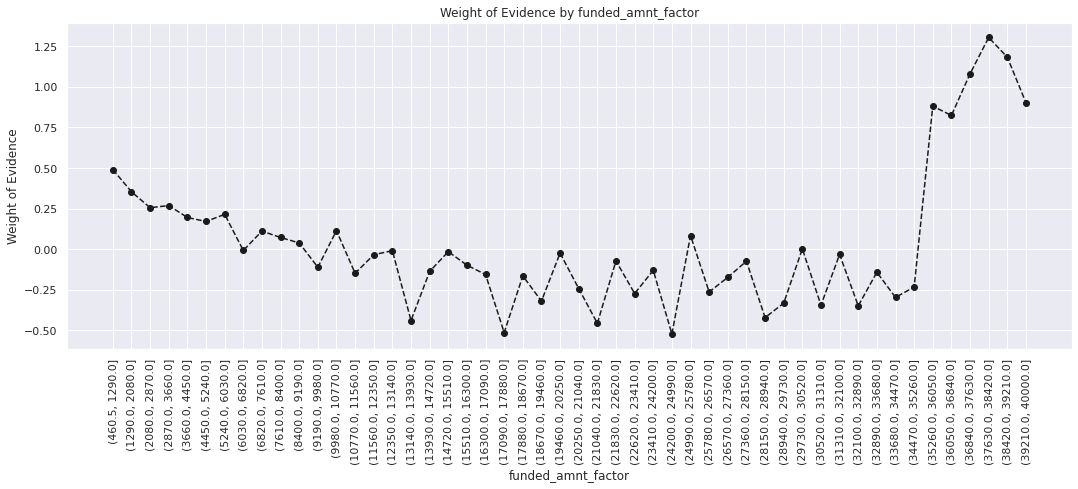

In [ ]:
plot_by_woe(g,90)

**There is no associatio between funded amount and WoE value**

## **mths_since_earliest_cr_line'(earliest_cr_line)**
**The date the borrower's earliest reported credit line was opened**

In [ ]:
data['mths_since_earliest_cr_line'].sample(5)

248039    314.0
482863    146.0
433797     87.0
37980     225.0
333199    445.0
Name: mths_since_earliest_cr_line, dtype: float64

In [ ]:
data['mths_since_earliest_cr_line'].min()

0.0

In [ ]:
input_pr['mths_since_earliest_cr_line_factor']=pd.cut(input_pr['mths_since_earliest_cr_line'],50)
data['mths_since_earliest_cr_line_factor']=pd.cut(data['mths_since_earliest_cr_line'],50)

In [ ]:
g=woe_con(input_pr,'mths_since_earliest_cr_line_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.815, 16.3]",4,0.250000,0.000009,1.0,3.0,0.000004,0.000013,-1.097585,NaN,NaN,inf
1,"(16.3, 32.6]",328,0.868902,0.000705,285.0,43.0,0.001226,0.000185,1.892316,0.618902,2.989901,inf
2,"(32.6, 48.9]",3106,0.685769,0.006675,2130.0,976.0,0.009160,0.004193,0.781442,0.183133,1.110874,inf
3,"(48.9, 65.2]",6582,0.566849,0.014145,3731.0,2851.0,0.016044,0.012248,0.270034,0.118920,0.511408,inf
4,"(65.2, 81.5]",9543,0.514513,0.020508,4910.0,4633.0,0.021114,0.019903,0.059097,0.052336,0.210937,inf
5,"(81.5, 97.8]",10149,0.510198,0.021811,5178.0,4971.0,0.022267,0.021355,0.041825,0.004315,0.017271,inf
6,"(97.8, 114.1]",13934,0.516937,0.029945,7203.0,6731.0,0.030975,0.028916,0.068801,0.006739,0.026976,inf
7,"(114.1, 130.4]",23659,0.508770,0.050844,12037.0,11622.0,0.051763,0.049927,0.036113,0.008167,0.032688,inf
8,"(130.4, 146.7]",34268,0.504173,0.073643,17277.0,16991.0,0.074296,0.072991,0.017720,0.004597,0.018393,inf
9,"(146.7, 163.0]",43205,0.485800,0.092849,20989.0,22216.0,0.090259,0.095437,-0.055787,0.018373,0.073507,inf


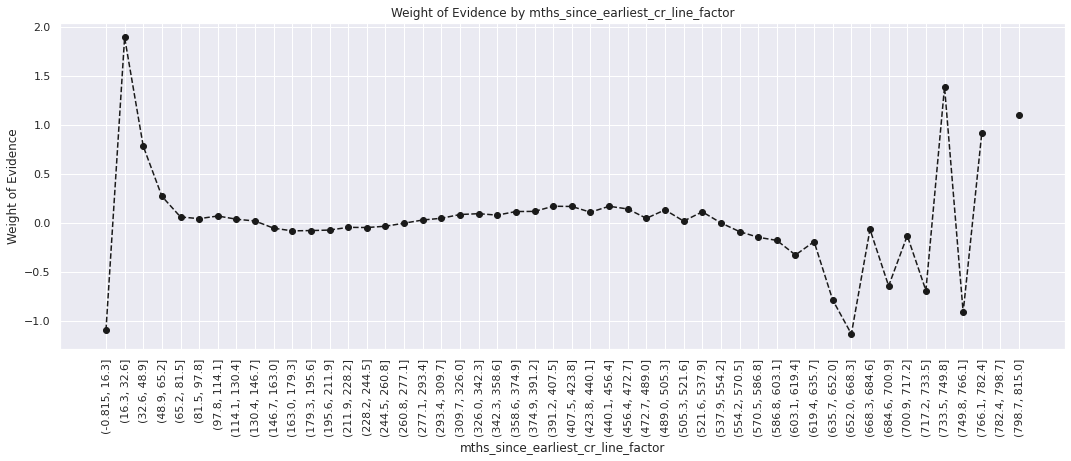

In [ ]:
plot_by_woe(g,90)

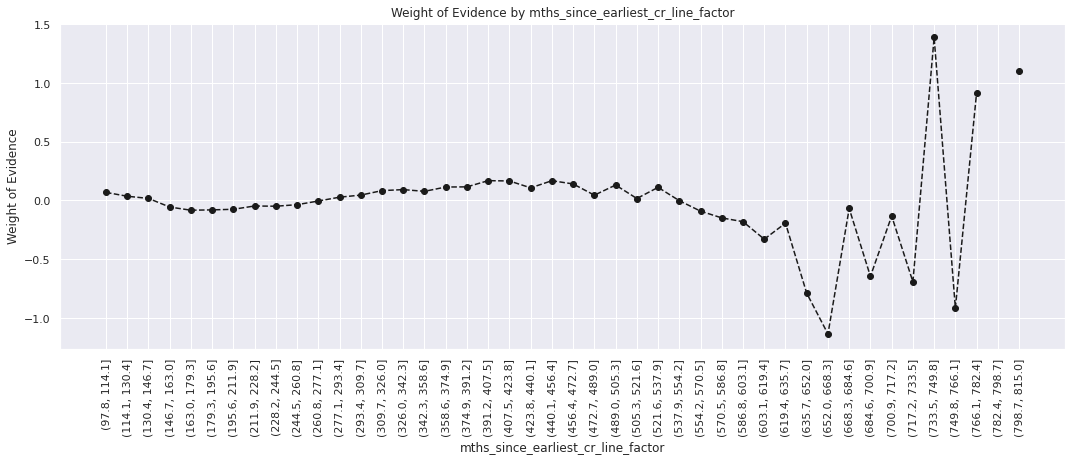

In [ ]:
plot_by_woe(g.iloc[6: , : ], 90)

In [ ]:

data['mths_since_earliest_cr_line:<140'] = np.where(data['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
data['mths_since_earliest_cr_line:141-164'] = np.where(data['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
data['mths_since_earliest_cr_line:165-247'] = np.where(data['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
data['mths_since_earliest_cr_line:248-270'] = np.where(data['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
data['mths_since_earliest_cr_line:271-352'] = np.where(data['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
data['mths_since_earliest_cr_line:>352'] = np.where(data['mths_since_earliest_cr_line'].isin(range(353, int(data['mths_since_earliest_cr_line'].max()))), 1, 0)

## **'installment'**
**The monthly payment owed by the borrower if the loan originates.**

In [ ]:
data['installment'].sample(5)

298123    402.83
385290    199.26
298823    234.92
374141    199.26
33350     402.54
Name: installment, dtype: float64

In [ ]:
input_pr['installment_factor']=pd.cut(input_pr['installment'],50)

g=woe_con(input_pr,'installment_factor',target_pr)
g

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(14.058, 49.797]",3167,0.629934,0.006806,1995.0,1172.0,0.008579,0.005035,0.532960,NaN,NaN,inf
1,"(49.797, 83.835]",7665,0.586693,0.016472,4497.0,3168.0,0.019338,0.013609,0.351337,0.043241,0.181622,inf
2,"(83.835, 117.872]",11976,0.577822,0.025737,6920.0,5056.0,0.029758,0.021720,0.314867,0.008870,0.036470,inf
3,"(117.872, 151.91]",13202,0.563854,0.028372,7444.0,5758.0,0.032011,0.024736,0.257845,0.013968,0.057022,inf
4,"(151.91, 185.947]",24652,0.554113,0.052978,13660.0,10992.0,0.058742,0.047220,0.218331,0.009741,0.039514,inf
5,"(185.947, 219.984]",23029,0.552564,0.049490,12725.0,10304.0,0.054721,0.044265,0.212064,0.001549,0.006268,inf
6,"(219.984, 254.022]",24591,0.536294,0.052847,13188.0,11403.0,0.056712,0.048986,0.146458,0.016270,0.065606,inf
7,"(254.022, 288.059]",31025,0.483062,0.066674,14987.0,16038.0,0.064449,0.068897,-0.066751,0.053232,0.213209,inf
8,"(288.059, 322.097]",30692,0.523785,0.065958,16076.0,14616.0,0.069132,0.062789,0.096238,0.040723,0.162988,inf
9,"(322.097, 356.134]",35294,0.480110,0.075848,16945.0,18349.0,0.072869,0.078825,-0.078575,0.043675,0.174813,inf


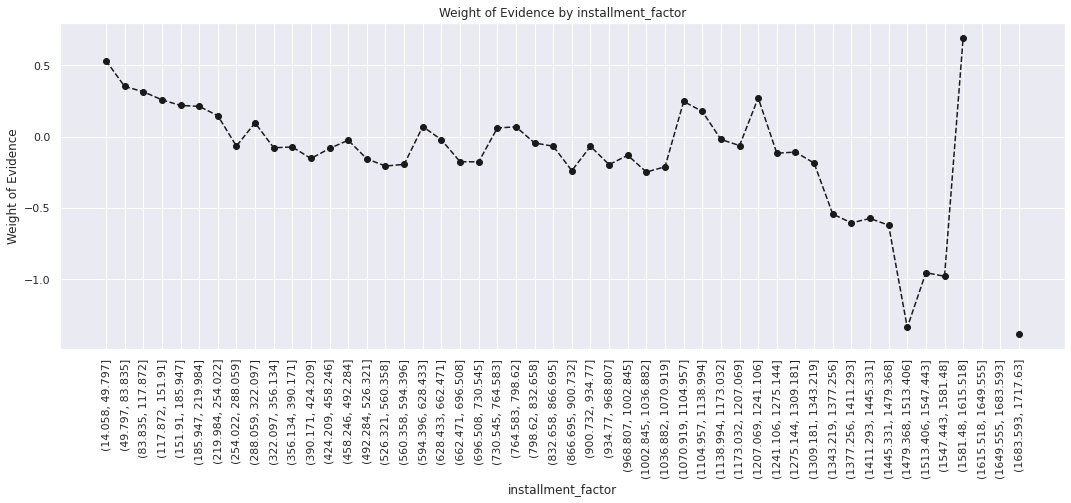

In [ ]:
plot_by_woe(g,90)

**There is no associatio between installment and WoE value**

## Preprocessing **'delinq_2yrs'**
**The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years**


In [ ]:
data['delinq_2yrs'].unique()

array([ 1.,  0.,  3.,  2., 11.,  4., 12.,  6.,  7.,  5., 19.,  8., 10.,
       21.,  9., 14., 13., 16., 15., 27., 17., 36., 20., 18., 25., 30.,
       29., 32., 28., 22., 24., 58.])

In [ ]:
g=woe_con(input_pr,'delinq_2yrs',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,0.0,374392,0.506958,0.804585,189801.0,184591.0,0.816201,0.792981,0.028861,NaN,NaN,inf
1,1.0,59733,0.478647,0.128369,28591.0,31142.0,0.122950,0.133782,-0.084438,0.028311,0.113299,inf
2,2.0,17963,0.461170,0.038603,8284.0,9679.0,0.035624,0.041580,-0.154605,0.017476,0.070167,inf
3,3.0,6723,0.443701,0.014448,2983.0,3740.0,0.012828,0.016067,-0.225129,0.017469,0.070523,inf
4,4.0,2919,0.447756,0.006273,1307.0,1612.0,0.005620,0.006925,-0.208714,0.004055,0.016415,inf
5,5.0,1484,0.433288,0.003189,643.0,841.0,0.002765,0.003613,-0.267420,0.014468,0.058706,inf
6,6.0,782,0.441176,0.001681,345.0,437.0,0.001484,0.001877,-0.235362,0.007888,0.032058,inf
7,7.0,494,0.443320,0.001062,219.0,275.0,0.000942,0.001181,-0.226672,0.002143,0.008689,inf
8,8.0,275,0.458182,0.000591,126.0,149.0,0.000542,0.000640,-0.166637,0.014862,0.060035,inf
9,9.0,166,0.397590,0.000357,66.0,100.0,0.000284,0.000430,-0.414488,0.060591,0.247851,inf


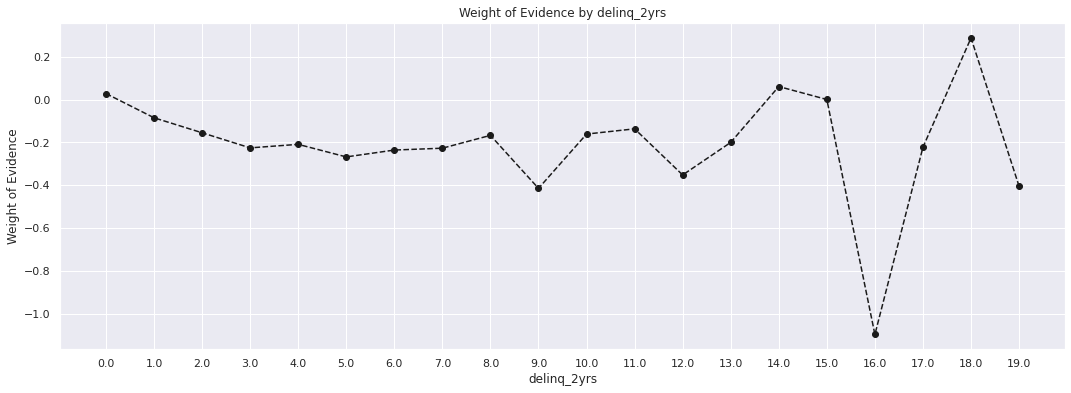

In [ ]:
plot_by_woe(g)

In [ ]:
data['delinq_2yrs:0'] = np.where((data['delinq_2yrs'] == 0), 1, 0)
data['delinq_2yrs:1-3'] = np.where((data['delinq_2yrs'] >= 1) & (data['delinq_2yrs'] <= 3), 1, 0)
data['delinq_2yrs:>=4'] = np.where((data['delinq_2yrs'] >= 9), 1, 0)

## Preprocesing 'inq_last_6mths'

Number of credit inquiries in past 6 months

In [ ]:
data['inq_last_6mths'].unique()

array([ 0.,  1.,  3.,  2.,  4.,  6.,  7.,  5.,  8., 12., 20., 18., 10.,
        9., 15., 14., 13., 33., 11., 17., 25., 32., 16.])

In [ ]:
g=woe_con(input_pr,'inq_last_6mths',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,0.0,265689,0.547023,0.570978,145338.0,120351.0,0.624997,0.517014,0.189677,NaN,NaN,inf
1,1.0,126683,0.465429,0.272247,58962.0,67721.0,0.253554,0.290922,-0.137476,0.081594,0.327153,inf
2,2.0,47716,0.409464,0.102544,19538.0,28178.0,0.084019,0.121049,-0.365153,0.055965,0.227677,inf
3,3.0,17967,0.360773,0.038612,6482.0,11485.0,0.027875,0.049338,-0.570985,0.048692,0.205832,inf
4,4.0,4967,0.312462,0.010674,1552.0,3415.0,0.006674,0.014670,-0.787606,0.048310,0.216620,inf
5,5.0,1785,0.302521,0.003836,540.0,1245.0,0.002322,0.005348,-0.834294,0.009941,0.046689,inf
6,6.0,343,0.259475,0.000737,89.0,254.0,0.000383,0.001091,-1.047671,0.043046,0.213376,inf
7,7.0,76,0.263158,0.000163,20.0,56.0,0.000086,0.000241,-1.028592,0.003683,0.019078,inf
8,8.0,46,0.195652,0.000099,9.0,37.0,0.000039,0.000159,-1.412666,0.067506,0.384074,inf
9,9.0,17,0.235294,0.000037,4.0,13.0,0.000017,0.000056,-1.177628,0.039642,0.235038,inf


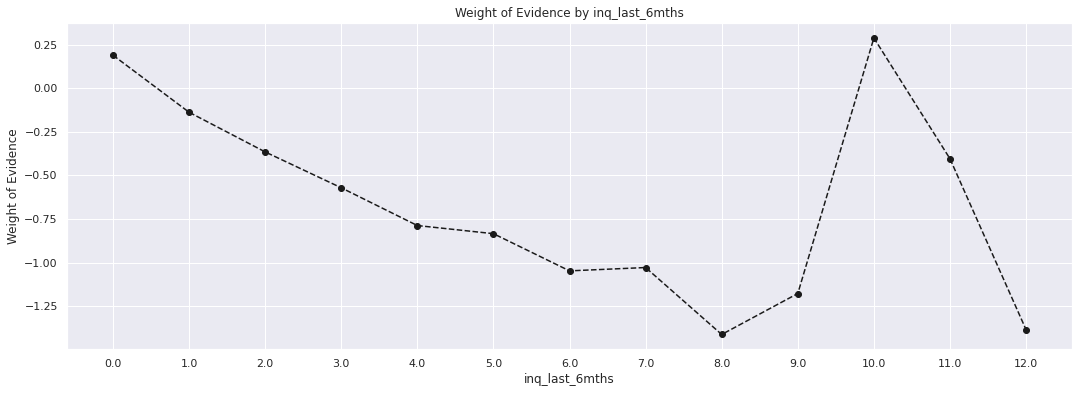

In [ ]:
plot_by_woe(g)

In [ ]:
data['inq_last_6mths:0'] = np.where((data['inq_last_6mths'] == 0), 1, 0)
data['inq_last_6mths:1-2'] = np.where((data['inq_last_6mths'] == 1) & (data['inq_last_6mths'] == 2), 1, 0)
data['inq_last_6mths:3'] = np.where((data['inq_last_6mths'] == 3), 1, 0)
data['inq_last_6mths:4-5'] = np.where((data['inq_last_6mths'] == 4) & (data['inq_last_6mths'] == 5), 1, 0)
data['inq_last_6mths:6'] = np.where((data['inq_last_6mths'] == 6), 1, 0)

## Preprocessing 'open_acc'
The number of open credit lines in the borrower's credit file.

In [ ]:
data['open_acc'].min()

0.0

In [ ]:
input_pr['open_acc_factor']=pd.cut(input_pr['open_acc'],50)

g=woe_con(input_pr,'open_acc_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.09, 1.8]",339,0.566372,0.000729,192.0,147.0,0.000826,0.000631,0.268090,NaN,NaN,inf
1,"(1.8, 3.6]",8182,0.548888,0.017583,4491.0,3691.0,0.019313,0.015856,0.197205,0.017484,7.088482e-02,inf
2,"(3.6, 5.4]",34182,0.531596,0.073459,18171.0,16011.0,0.078141,0.068781,0.127578,0.017292,6.962704e-02,inf
3,"(5.4, 7.2]",63759,0.517590,0.137021,33001.0,30758.0,0.141914,0.132133,0.071415,0.014006,5.616319e-02,inf
4,"(7.2, 9.0]",78871,0.505534,0.169497,39872.0,38999.0,0.171461,0.167535,0.023166,0.012055,4.824942e-02,inf
5,"(9.0, 10.8]",39495,0.496873,0.084877,19624.0,19871.0,0.084389,0.085363,-0.011481,0.008661,3.464639e-02,inf
6,"(10.8, 12.6]",69297,0.487770,0.148922,33801.0,35496.0,0.145354,0.152487,-0.047902,0.009103,3.642155e-02,inf
7,"(12.6, 14.4]",53713,0.488653,0.115432,26247.0,27466.0,0.112870,0.117991,-0.044370,0.000883,3.532447e-03,inf
8,"(14.4, 16.2]",38550,0.489468,0.082846,18869.0,19681.0,0.081142,0.084547,-0.041106,0.000816,3.263840e-03,inf
9,"(16.2, 18.0]",26655,0.488801,0.057283,13029.0,13626.0,0.056029,0.058536,-0.043775,0.000667,2.668751e-03,inf


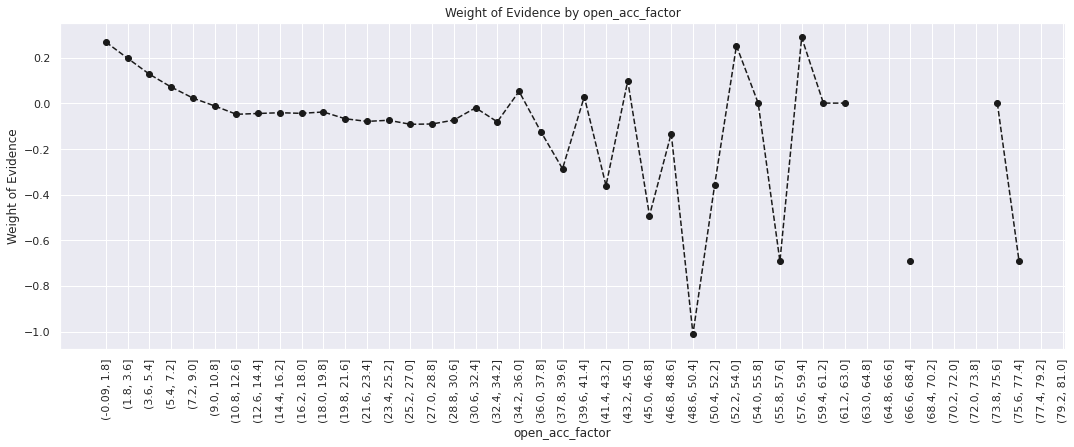

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['open_acc:0-5'] = np.where( (data['open_acc'] <= 5), 1, 0)
data['open_acc:5-7'] = np.where((data['open_acc'] > 5) & (data['open_acc'] <= 7), 1, 0)
data['open_acc:7-9'] = np.where((data['open_acc'] > 7) & (data['open_acc'] <= 9), 1, 0)
data['open_acc:9-23'] = np.where((data['open_acc'] > 9) & (data['open_acc'] <= 23), 1, 0)
data['open_acc:26-31'] = np.where((data['open_acc'] >23 ) & (data['open_acc'] <= 31), 1, 0)
data['open_acc:>=31'] = np.where((data['open_acc'] > 31), 1, 0)

## Preprocessing 'pub_rec'
Number of derogatory public records

In [ ]:
data['pub_rec'].unique()

array([ 0.,  1.,  2.,  3.,  5.,  9.,  4.,  7.,  6.,  8., 11., 19., 16.,
       13., 22., 15., 14., 10., 12., 17., 44., 45., 40., 25., 61., 18.,
       86., 21., 20., 28., 49., 46., 37.])

In [ ]:
g=woe_con(input_pr,'pub_rec',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,0.0,384951,0.511714,0.827277,196985.0,187966.0,0.847094,0.807480,0.047894,NaN,NaN,inf
1,1.0,67945,0.449628,0.146017,30550.0,37395.0,0.131374,0.160645,-0.201145,0.062086,0.249039,inf
2,2.0,8197,0.398804,0.017616,3269.0,4928.0,0.014058,0.021170,-0.409422,0.050824,0.208277,inf
3,3.0,2364,0.406091,0.005080,960.0,1404.0,0.004128,0.006031,-0.379120,0.007287,0.030302,inf
4,4.0,953,0.399790,0.002048,381.0,572.0,0.001638,0.002457,-0.405312,0.006301,0.026192,inf
5,5.0,437,0.423341,0.000939,185.0,252.0,0.000796,0.001083,-0.308046,0.023551,0.097266,inf
6,6.0,230,0.426087,0.000494,98.0,132.0,0.000421,0.000567,-0.296807,0.002746,0.011239,inf
7,7.0,103,0.427184,0.000221,44.0,59.0,0.000189,0.000253,-0.292321,0.001098,0.004487,inf
8,8.0,57,0.614035,0.000122,35.0,22.0,0.000151,0.000095,0.465333,0.186851,0.757653,inf
9,9.0,21,0.428571,0.000045,9.0,12.0,0.000039,0.000052,-0.286655,0.185464,0.751988,inf


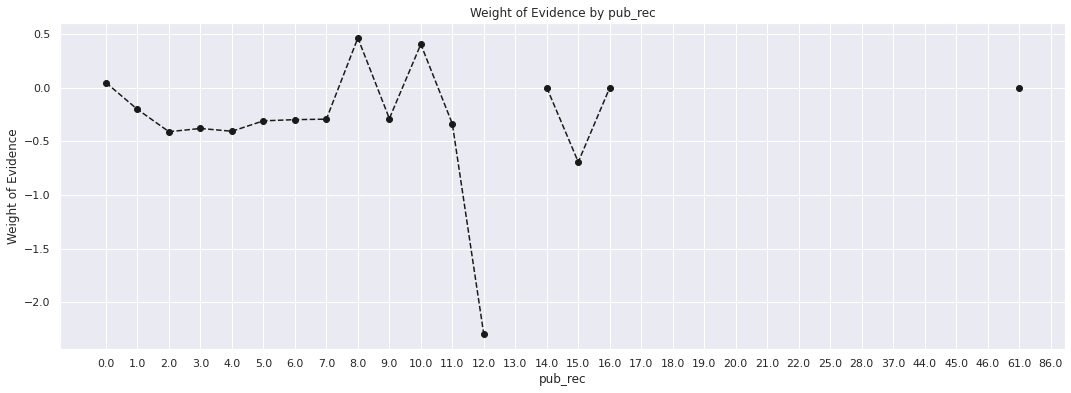

In [ ]:
plot_by_woe(g)

In [ ]:
data['pub_rec:0'] = np.where((data['pub_rec'] == 0), 1, 0)
data['pub_rec:1'] = np.where((data['pub_rec'] == 1), 1, 0)
data['pub_rec:>=2'] = np.where((data['pub_rec'] >= 2), 1, 0)

## Preprocessing 'total_acc'
The total number of credit lines currently in the borrower's credit file

In [ ]:
data['total_acc'].value_counts()

20.0     21216
21.0     21032
19.0     20948
17.0     20837
18.0     20799
         ...  
148.0        1
176.0        1
151.0        1
114.0        1
169.0        1
Name: total_acc, Length: 132, dtype: int64

In [ ]:
input_pr['total_acc_factor']=pd.cut(input_pr['total_acc'],50)

g=woe_con(input_pr,'total_acc_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.173, 3.46]",1039,0.555342,0.002233,577.0,462.0,0.002481,0.001985,0.223305,NaN,NaN,inf
1,"(3.46, 6.92]",9859,0.528857,0.021187,5214.0,4645.0,0.022422,0.019954,0.116583,0.026485,0.106721,inf
2,"(6.92, 10.38]",34056,0.514682,0.073188,17528.0,16528.0,0.075376,0.071002,0.059771,0.014175,0.056812,inf
3,"(10.38, 13.84]",39810,0.505828,0.085553,20137.0,19673.0,0.086595,0.084513,0.024339,0.008854,0.035432,inf
4,"(13.84, 17.3]",63953,0.502963,0.137438,32166.0,31787.0,0.138323,0.136553,0.012880,0.002865,0.011459,inf
5,"(17.3, 20.76]",50401,0.502867,0.108314,25345.0,25056.0,0.108991,0.107638,0.012495,0.000096,0.000384,inf
6,"(20.76, 24.22]",64665,0.499265,0.138968,32285.0,32380.0,0.138835,0.139101,-0.001911,0.003602,0.014406,inf
7,"(24.22, 27.68]",42755,0.498328,0.091882,21306.0,21449.0,0.091622,0.092142,-0.005662,0.000938,0.003751,inf
8,"(27.68, 31.14]",46855,0.497044,0.100693,23289.0,23566.0,0.100150,0.101237,-0.010797,0.001284,0.005135,inf
9,"(31.14, 34.6]",27732,0.494591,0.059597,13716.0,14016.0,0.058983,0.060211,-0.020609,0.002453,0.009813,inf


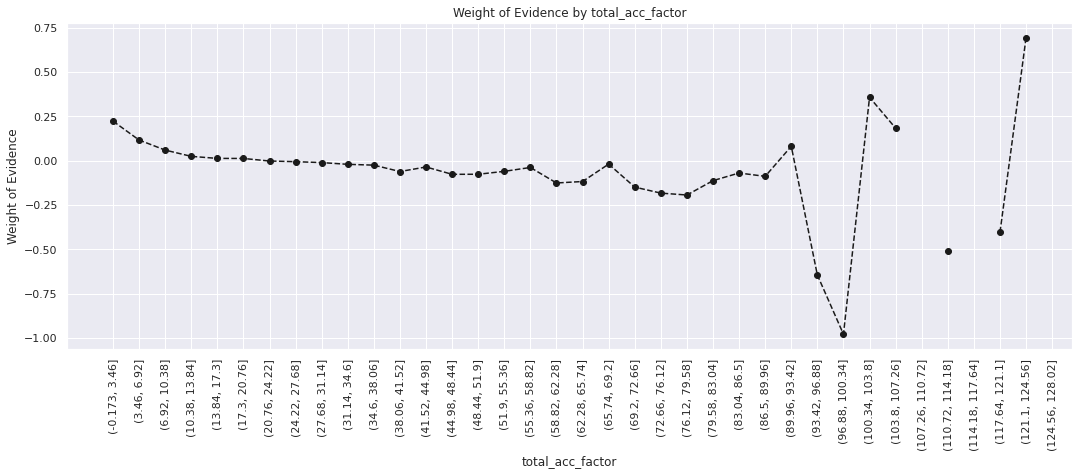

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['total_acc:<=23'] = np.where((data['total_acc'] <= 23), 1, 0)
data['total_acc:24-48'] = np.where((data['total_acc'] >= 24) & (data['total_acc'] <= 48), 1, 0)
data['total_acc:>=49'] = np.where((data['total_acc'] >= 49), 1, 0)

## Preprocessing 'acc_now_delinq'
The number of accounts on which the borrower is now delinquent (behind on payments).

In [ ]:
data['acc_now_delinq'].unique()

array([0., 4., 1., 3., 2., 5., 6.])

In [ ]:
g=woe_con(input_pr,'acc_now_delinq',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,0.0,463238,0.500082,0.995519,231657.0,231581.0,0.996194,0.994845,0.001355,NaN,NaN,inf
1,1.0,1974,0.430091,0.004242,849.0,1125.0,0.003651,0.004833,-0.280452,0.069991,0.281807,inf
2,2.0,92,0.304348,0.000198,28.0,64.0,0.000120,0.000275,-0.825651,0.125743,0.545199,inf
3,3.0,14,0.428571,0.000030,6.0,8.0,0.000026,0.000034,-0.286655,0.124224,0.538997,inf
4,4.0,3,0.666667,0.000006,2.0,1.0,0.000009,0.000004,0.694174,0.238095,0.980829,inf
5,5.0,1,0.000000,0.000002,0.0,1.0,0.000000,0.000004,-inf,0.666667,inf,inf
6,6.0,1,0.000000,0.000002,0.0,1.0,0.000000,0.000004,-inf,0.000000,NaN,inf


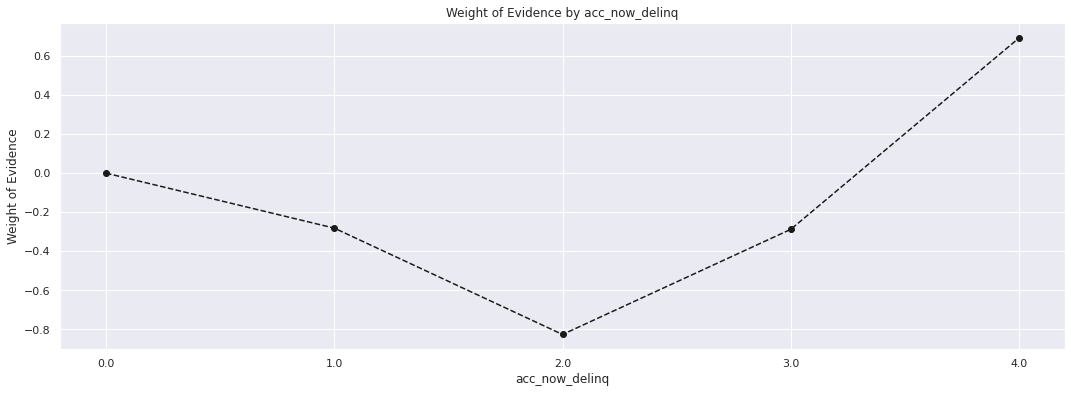

In [ ]:
plot_by_woe(g)

In [ ]:
data['acc_now_delinq:0'] = np.where((data['acc_now_delinq'] == 0), 1, 0)
data['acc_now_delinq:>=1'] = np.where((data['acc_now_delinq'] >= 1), 1, 0)

## Preprocessing 'total_rev_hi_lim'
Total revolving high credit/credit limit

In [ ]:
data['total_rev_hi_lim'].median()

23300.0

In [ ]:
input_pr['total_rev_hi_lim_factor']=pd.cut(input_pr['total_rev_hi_lim'],2000)

g=woe_con(input_pr,'total_rev_hi_lim_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-9999.999, 5000.0]",18996,0.445831,0.040823,8469.0,10527.0,0.036419,0.045223,-0.216504,NaN,NaN,inf
1,"(5000.0, 9999.999]",51999,0.452009,0.111748,23504.0,28495.0,0.101074,0.122411,-0.191531,0.006178,0.024973,inf
2,"(9999.999, 14999.998]",64138,0.456375,0.137835,29271.0,34867.0,0.125874,0.149785,-0.173916,0.004367,0.017614,inf
3,"(14999.998, 19999.998]",61267,0.461194,0.131666,28256.0,33011.0,0.121509,0.141811,-0.154508,0.004819,0.019409,inf
4,"(19999.998, 24999.997]",52254,0.478547,0.112296,25006.0,27248.0,0.107533,0.117054,-0.084837,0.017353,0.069671,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


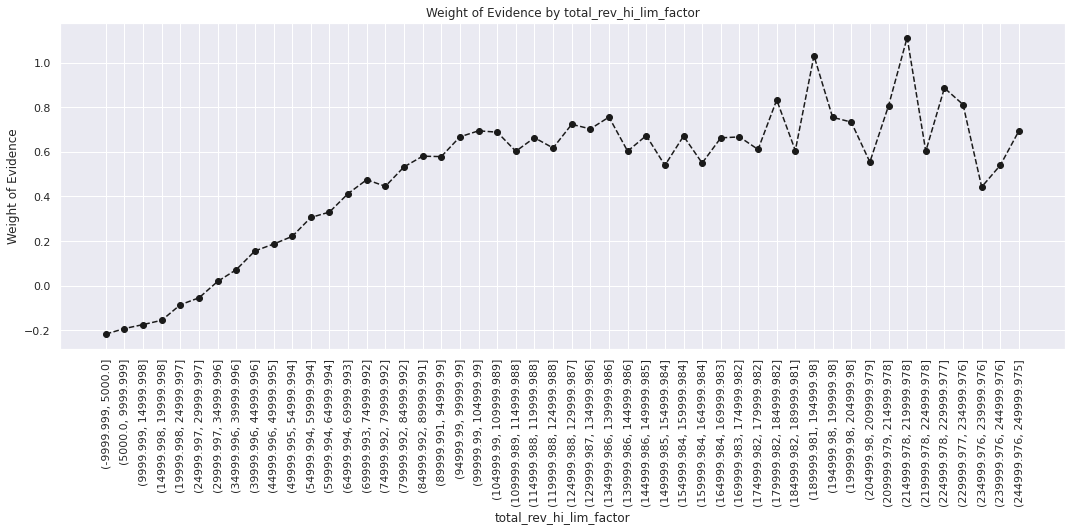

In [ ]:
plot_by_woe(g.iloc[: 50, : ], 90)

In [ ]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
data['total_rev_hi_lim:<=5K'] = np.where((data['total_rev_hi_lim'] <= 5000), 1, 0)
data['total_rev_hi_lim:5K-10K'] = np.where((data['total_rev_hi_lim'] > 5000) & (data['total_rev_hi_lim'] <= 10000), 1, 0)
data['total_rev_hi_lim:10K-20K'] = np.where((data['total_rev_hi_lim'] > 10000) & (data['total_rev_hi_lim'] <= 20000), 1, 0)
data['total_rev_hi_lim:20K-30K'] = np.where((data['total_rev_hi_lim'] > 20000) & (data['total_rev_hi_lim'] <= 30000), 1, 0)
data['total_rev_hi_lim:30K-40K'] = np.where((data['total_rev_hi_lim'] > 30000) & (data['total_rev_hi_lim'] <= 40000), 1, 0)
data['total_rev_hi_lim:40K-55K'] = np.where((data['total_rev_hi_lim'] > 40000) & (data['total_rev_hi_lim'] <= 55000), 1, 0)
data['total_rev_hi_lim:55K-95K'] = np.where((data['total_rev_hi_lim'] > 55000) & (data['total_rev_hi_lim'] <= 95000), 1, 0)
data['total_rev_hi_lim:>95K'] = np.where((data['total_rev_hi_lim'] > 95000), 1, 0)

## Preprocessing 'annual_inc'

In [ ]:
data['annual_inc'].min()

0.0

In [ ]:
input_pr['annual_inc_factor']=pd.cut(input_pr['annual_inc'],50)

g=woe_con(input_pr,'annual_inc_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-10999.2, 219984.0]",457446,0.497580,0.983072,227616.0,229830.0,0.978817,0.987323,-0.008653,NaN,NaN,inf
1,"(219984.0, 439968.0]",6897,0.619400,0.014822,4272.0,2625.0,0.018371,0.011277,0.488028,0.121820,0.496681,inf
2,"(439968.0, 659952.0]",670,0.685075,0.001440,459.0,211.0,0.001974,0.000906,0.778219,0.065675,0.290191,inf
3,"(659952.0, 879936.0]",164,0.658537,0.000352,108.0,56.0,0.000464,0.000241,0.657807,0.026538,0.120413,inf
4,"(879936.0, 1099920.0]",63,0.603175,0.000135,38.0,25.0,0.000163,0.000107,0.419738,0.055362,0.238069,inf
5,"(1099920.0, 1319904.0]",20,0.650000,0.000043,13.0,7.0,0.000056,0.000030,0.620066,0.046825,0.200329,inf
6,"(1319904.0, 1539888.0]",15,0.733333,0.000032,11.0,4.0,0.000047,0.000017,1.012628,0.083333,0.392562,inf
7,"(1539888.0, 1759872.0]",5,0.200000,0.000011,1.0,4.0,0.000004,0.000017,-1.385267,0.533333,2.397895,inf
8,"(1759872.0, 1979856.0]",1,1.000000,0.000002,1.0,0.0,0.000004,0.000000,inf,0.800000,inf,inf
9,"(1979856.0, 2199840.0]",4,0.750000,0.000009,3.0,1.0,0.000013,0.000004,1.099640,0.250000,inf,inf


In [ ]:
input_pr['annual_inc_factor']=pd.cut(input_pr['annual_inc'],100)

g=woe_con(input_pr,'annual_inc_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-10999.2, 109992.0]",394962,0.484920,0.848791,191525.0,203437.0,0.823615,0.873942,-0.059311,NaN,NaN,inf
1,"(109992.0, 219984.0]",62484,0.577604,0.134281,36091.0,26393.0,0.155202,0.113381,0.313972,0.092684,0.373283,inf
2,"(219984.0, 329976.0]",5744,0.611421,0.012344,3512.0,2232.0,0.015103,0.009588,0.454315,0.033817,0.140343,inf
3,"(329976.0, 439968.0]",1153,0.659150,0.002478,760.0,393.0,0.003268,0.001688,0.660536,0.047729,0.206221,inf
4,"(439968.0, 549960.0]",453,0.693157,0.000974,314.0,139.0,0.001350,0.000597,0.815946,0.034007,0.155410,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(10449240.0, 10559232.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(10559232.0, 10669224.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(10669224.0, 10779216.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(10779216.0, 10889208.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [ ]:
df_inputs_prepr_temp = input_pr.loc[input_pr['annual_inc'] <= 140000, : ]

In [ ]:
df_inputs_prepr_temp['annual_inc_factor'] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
g=woe_con(df_inputs_prepr_temp,'annual_inc_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-140.0, 2800.0]",322,0.692547,0.000742,223.0,99.0,0.001043,0.000450,0.841707,NaN,NaN,0.024859
1,"(2800.0, 5600.0]",78,0.705128,0.000180,55.0,23.0,0.000257,0.000104,0.901494,0.012582,0.059787,0.024859
2,"(5600.0, 8400.0]",174,0.534483,0.000401,93.0,81.0,0.000435,0.000368,0.167806,0.170645,0.733689,0.024859
3,"(8400.0, 11200.0]",763,0.473132,0.001759,361.0,402.0,0.001689,0.001826,-0.077919,0.061350,0.245724,0.024859
4,"(11200.0, 14000.0]",1341,0.440716,0.003091,591.0,750.0,0.002765,0.003407,-0.208602,0.032416,0.130683,0.024859
5,"(14000.0, 16800.0]",2067,0.458636,0.004764,948.0,1119.0,0.004436,0.005083,-0.136181,0.017920,0.072421,0.024859
6,"(16800.0, 19600.0]",2498,0.448359,0.005757,1120.0,1378.0,0.005240,0.006259,-0.177649,0.010277,0.041468,0.024859
7,"(19600.0, 22400.0]",4886,0.442898,0.011261,2164.0,2722.0,0.010125,0.012364,-0.199753,0.005461,0.022104,0.024859
8,"(22400.0, 25200.0]",8167,0.448145,0.018823,3660.0,4507.0,0.017125,0.020472,-0.178513,0.005247,0.021240,0.024859
9,"(25200.0, 28000.0]",7083,0.440774,0.016325,3122.0,3961.0,0.014608,0.017992,-0.208367,0.007371,0.029854,0.024859


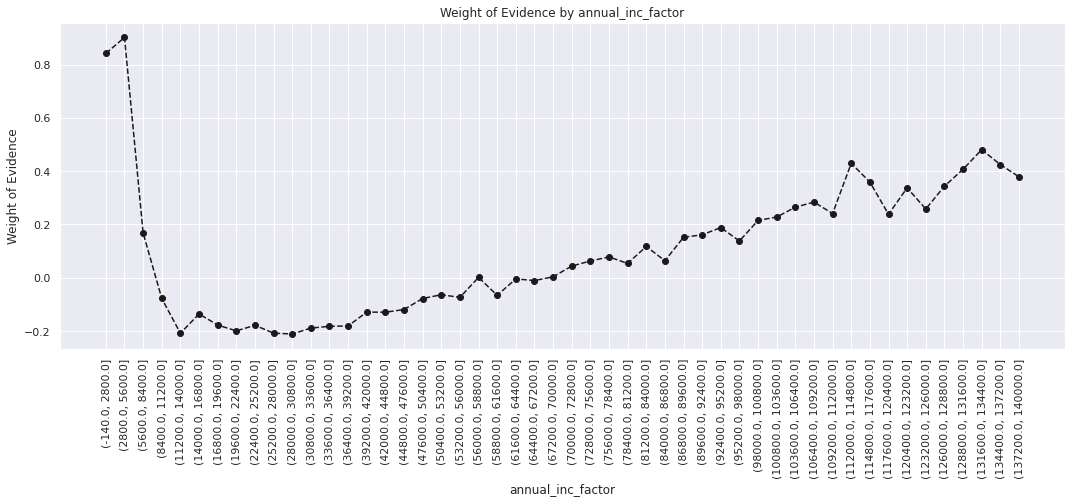

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['annual_inc:<20K'] = np.where((data['annual_inc'] <= 20000), 1, 0)
data['annual_inc:20K-30K'] = np.where((data['annual_inc'] > 20000) & (data['annual_inc'] <= 30000), 1, 0)
data['annual_inc:30K-40K'] = np.where((data['annual_inc'] > 30000) & (data['annual_inc'] <= 40000), 1, 0)
data['annual_inc:40K-50K'] = np.where((data['annual_inc'] > 40000) & (data['annual_inc'] <= 50000), 1, 0)
data['annual_inc:50K-60K'] = np.where((data['annual_inc'] > 50000) & (data['annual_inc'] <= 60000), 1, 0)
data['annual_inc:60K-70K'] = np.where((data['annual_inc'] > 60000) & (data['annual_inc'] <= 70000), 1, 0)
data['annual_inc:70K-80K'] = np.where((data['annual_inc'] > 70000) & (data['annual_inc'] <= 80000), 1, 0)
data['annual_inc:80K-90K'] = np.where((data['annual_inc'] > 80000) & (data['annual_inc'] <= 90000), 1, 0)
data['annual_inc:90K-100K'] = np.where((data['annual_inc'] > 90000) & (data['annual_inc'] <= 100000), 1, 0)
data['annual_inc:100K-120K'] = np.where((data['annual_inc'] > 100000) & (data['annual_inc'] <= 120000), 1, 0)
data['annual_inc:120K-140K'] = np.where((data['annual_inc'] > 120000) & (data['annual_inc'] <= 140000), 1, 0)
data['annual_inc:>140K'] = np.where((data['annual_inc'] > 140000), 1, 0)

## Preporcessing 'mths_since_last_delinq'
The number of months since the borrower's last delinquency.

In [ ]:
data['mths_since_last_delinq'].unique()

array([ 22.,  nan,   8.,  12.,   3.,  27.,  41.,  72.,  14.,  42.,   6.,
        81.,  79.,  25.,  18.,  13.,  30.,  45.,  26.,  10.,  24.,  44.,
        58.,  34.,  67.,  33.,   4.,  77.,  19.,  65.,  63.,  43.,  69.,
        35.,  23.,  31.,  57.,   7.,  37.,  29.,  49.,  70.,  66.,  20.,
        36.,   5.,  46.,  28.,  21.,   1.,   9.,  68.,   2.,  38.,  15.,
        61.,  40.,  80.,  75.,  52.,  11.,  51.,  82.,  56.,  32.,  62.,
        17.,  50.,  64.,  47.,  71.,  53.,  74.,  39.,  60.,  76.,  88.,
        16.,  54., 104.,  59.,  73.,  78.,  48.,   0.,  86.,  55.,  96.,
        90.,  84.,  83.,  93., 102.,  89., 158.,  85., 109.,  98.,  97.,
       105.,  87., 123., 115.,  92., 107.,  99., 120., 103., 129.,  95.,
       101.,  91., 111., 110., 127., 135., 134., 100., 106., 112., 202.,
       130., 122., 170., 114., 117., 226., 108., 125.,  94., 113., 124.,
       152., 148., 180., 116., 121., 118., 133., 161., 160., 131., 162.,
       192., 146., 153., 126., 159., 143., 141., 15

In [ ]:
df_inputs_prepr_temp = input_pr[pd.notnull(input_pr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
g = woe_con(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', target_pr[df_inputs_prepr_temp.index])
g


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.226, 4.52]",10693,0.453661,0.046061,4851.0,5842.0,0.043090,0.048859,-0.125658,NaN,NaN,inf
1,"(4.52, 9.04]",21364,0.462601,0.092028,9883.0,11481.0,0.087787,0.096021,-0.089647,0.008939,0.036011,inf
2,"(9.04, 13.56]",17187,0.473672,0.074035,8141.0,9046.0,0.072314,0.075656,-0.045180,0.011071,0.044468,inf
3,"(13.56, 18.08]",20493,0.472747,0.088276,9688.0,10805.0,0.086055,0.090367,-0.048891,0.000925,0.003711,inf
4,"(18.08, 22.6]",15447,0.486567,0.066540,7516.0,7931.0,0.066762,0.066330,0.006485,0.013820,0.055376,inf
5,"(22.6, 27.12]",18869,0.489374,0.081280,9234.0,9635.0,0.082022,0.080582,0.017720,0.002807,0.011235,inf
6,"(27.12, 31.64]",14380,0.486509,0.061944,6996.0,7384.0,0.062143,0.061756,0.006253,0.002865,0.011467,inf
7,"(31.64, 36.16]",16615,0.497322,0.071571,8263.0,8352.0,0.073397,0.069851,0.049517,0.010813,0.043264,inf
8,"(36.16, 40.68]",12672,0.496922,0.054586,6297.0,6375.0,0.055934,0.053317,0.047919,0.000399,0.001597,inf
9,"(40.68, 45.2]",15029,0.500166,0.064739,7517.0,7512.0,0.066771,0.062826,0.060895,0.003244,0.012976,inf


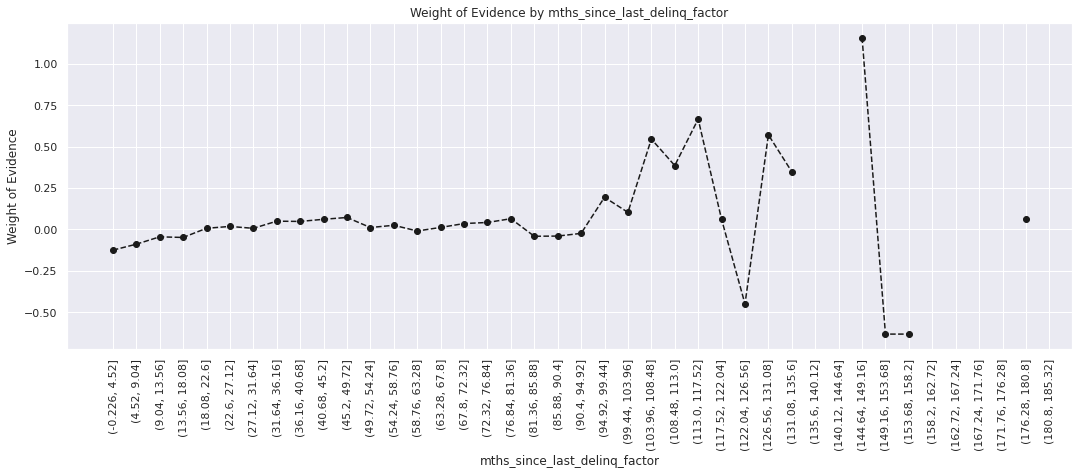

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['mths_since_last_delinq:Missing'] = np.where((data['mths_since_last_delinq'].isnull()), 1, 0)
data['mths_since_last_delinq:0-3'] = np.where((data['mths_since_last_delinq'] >= 0) & (data['mths_since_last_delinq'] <= 3), 1, 0)
data['mths_since_last_delinq:4-30'] = np.where((data['mths_since_last_delinq'] >= 4) & (data['mths_since_last_delinq'] <= 30), 1, 0)
data['mths_since_last_delinq:31-56'] = np.where((data['mths_since_last_delinq'] >= 31) & (data['mths_since_last_delinq'] <= 56), 1, 0)
data['mths_since_last_delinq:>=57'] = np.where((data['mths_since_last_delinq'] >= 57), 1, 0)

## Preprocessing 'dti'
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [ ]:
data['dti'].min()

0.0

In [ ]:
input_pr['dti_factor']=pd.cut(input_pr['dti'],100)
g=woe_con(input_pr,'dti_factor',target_pr)
g

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.999, 9.99]",75610,0.572768,0.162580,43307.0,32303.0,0.186381,0.138815,0.294655,NaN,NaN,inf
1,"(9.99, 19.98]",183144,0.525417,0.393805,96227.0,86917.0,0.414134,0.373506,0.103257,0.047351,0.191398,inf
2,"(19.98, 29.97]",149421,0.459273,0.321292,68625.0,80796.0,0.295343,0.347202,-0.161770,0.066144,0.265027,inf
3,"(29.97, 39.96]",51905,0.411174,0.111609,21342.0,30563.0,0.091850,0.131337,-0.357612,0.048099,0.195843,inf
4,"(39.96, 49.95]",2649,0.528501,0.005696,1400.0,1249.0,0.006025,0.005367,0.115630,0.117327,0.473242,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(949.05, 959.04]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(959.04, 969.03]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(969.03, 979.02]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(979.02, 989.01]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


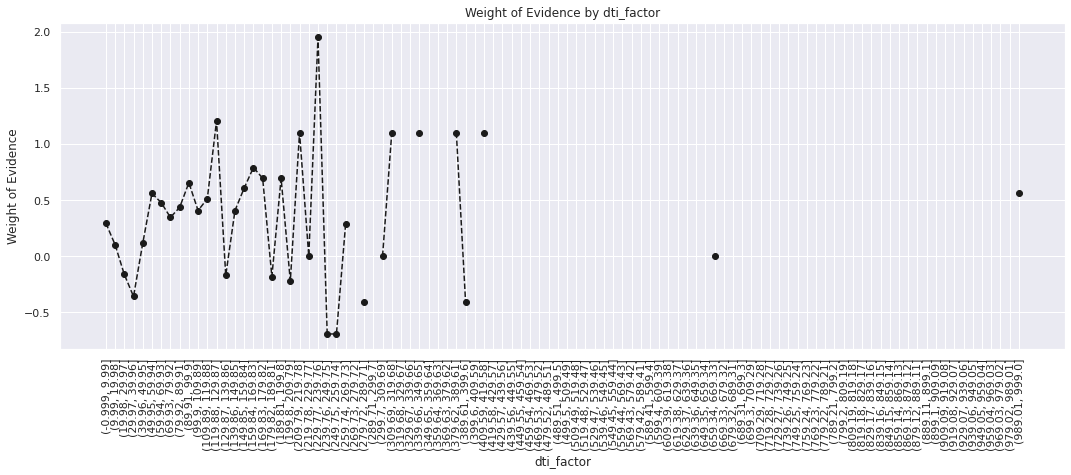

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['dti:<=1.4'] = np.where((data['dti'] <= 1.4), 1, 0)
data['dti:1.4-3.5'] = np.where((data['dti'] > 1.4) & (data['dti'] <= 3.5), 1, 0)
data['dti:3.5-7.7'] = np.where((data['dti'] > 3.5) & (data['dti'] <= 7.7), 1, 0)
data['dti:7.7-10.5'] = np.where((data['dti'] > 7.7) & (data['dti'] <= 10.5), 1, 0)
data['dti:10.5-16.1'] = np.where((data['dti'] > 10.5) & (data['dti'] <= 16.1), 1, 0)
data['dti:16.1-20.3'] = np.where((data['dti'] > 16.1) & (data['dti'] <= 20.3), 1, 0)
data['dti:20.3-21.7'] = np.where((data['dti'] > 20.3) & (data['dti'] <= 21.7), 1, 0)
data['dti:21.7-22.4'] = np.where((data['dti'] > 21.7) & (data['dti'] <= 22.4), 1, 0)
data['dti:22.4-35'] = np.where((data['dti'] > 22.4) & (data['dti'] <= 35), 1, 0)
data['dti:>35'] = np.where((data['dti'] > 35), 1, 0)

## Preprocessing 'mths_since_last_record'
The number of months since the last public record.

In [ ]:
data['mths_since_last_record'].unique()

array([ nan,  41., 114.,  81.,  47.,  64.,  74., 101.,  88.,  70.,  53.,
        92., 118.,  46.,  71.,  55.,  79.,  61.,  80.,  72.,  43.,  94.,
        89.,  42.,  83.,  36.,  68.,  58.,  73.,  66.,  82.,  51., 115.,
        63.,  23.,  96., 109.,  34.,  48.,  40.,  84.,  78.,  97., 104.,
        86.,   7.,  85.,  69.,  59.,  54., 102., 117.,  33., 116.,  99.,
        57.,  10., 112.,  65.,  26.,  27.,  98., 103.,  52.,  95.,  77.,
        60., 113.,  87.,  29., 105.,  30.,  22., 108.,  28.,  13., 107.,
        37.,  62.,  18., 110.,  32., 119.,   0.,  67., 100.,  91.,  11.,
        49.,  90.,  76.,  38.,  21.,  17.,  31.,  39.,  15.,  56.,  45.,
       106.,   9.,  50.,  24.,   4.,  75.,  19.,  16.,  93.,  20., 111.,
        14.,  35.,   6.,  25.,   5.,  12.,   8.,  44.,   1.,   3.,   2.,
       120., 124., 121., 123., 129., 126., 122.])

In [ ]:
df_inputs_prepr_temp = input_pr[pd.notnull(input_pr['mths_since_last_record'])]
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
g = woe_con(df_inputs_prepr_temp, 'mths_since_last_record_factor', target_pr[df_inputs_prepr_temp.index])
g

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_default,prop_n_good,prop_n_default,WoE,diff_prop_good,diif_WoE,IV
0,"(-0.129, 2.58]",466,0.317597,0.005772,148.0,318.0,0.004150,0.007055,-0.530720,NaN,NaN,inf
1,"(2.58, 5.16]",265,0.396226,0.003282,105.0,160.0,0.002944,0.003550,-0.187094,0.078630,0.343626,inf
2,"(5.16, 7.74]",225,0.400000,0.002787,90.0,135.0,0.002524,0.002995,-0.171346,0.003774,0.015748,inf
3,"(7.74, 10.32]",464,0.405172,0.005747,188.0,276.0,0.005271,0.006124,-0.149839,0.005172,0.021506,inf
4,"(10.32, 12.9]",366,0.363388,0.004533,133.0,233.0,0.003729,0.005170,-0.326570,0.041784,0.176730,inf
5,"(12.9, 15.48]",529,0.448015,0.006552,237.0,292.0,0.006645,0.006479,0.025426,0.084627,0.351996,inf
6,"(15.48, 18.06]",568,0.434859,0.007035,247.0,321.0,0.006926,0.007122,-0.027933,0.013156,0.053359,inf
7,"(18.06, 20.64]",449,0.467706,0.005561,210.0,239.0,0.005888,0.005303,0.104763,0.032847,0.132697,inf
8,"(20.64, 23.22]",680,0.420588,0.008423,286.0,394.0,0.008019,0.008742,-0.086240,0.047118,0.191003,inf
9,"(23.22, 25.8]",554,0.427798,0.006862,237.0,317.0,0.006645,0.007033,-0.056722,0.007210,0.029517,inf


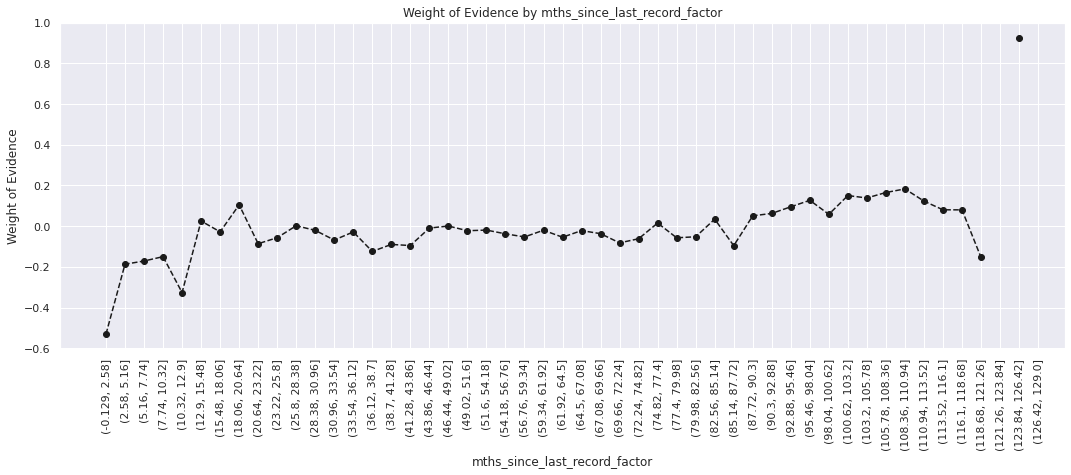

In [ ]:
plot_by_woe(g,90)

In [ ]:
data['mths_since_last_record:Missing'] = np.where((data['mths_since_last_record'].isnull()), 1, 0)
data['mths_since_last_record:0-2'] = np.where((data['mths_since_last_record'] >= 0) & (data['mths_since_last_record'] <= 2), 1, 0)
data['mths_since_last_record:3-20'] = np.where((data['mths_since_last_record'] >= 3) & (data['mths_since_last_record'] <= 20), 1, 0)
data['mths_since_last_record:21-31'] = np.where((data['mths_since_last_record'] >= 21) & (data['mths_since_last_record'] <= 31), 1, 0)
data['mths_since_last_record:32-80'] = np.where((data['mths_since_last_record'] >= 32) & (data['mths_since_last_record'] <= 80), 1, 0)
data['mths_since_last_record:81-86'] = np.where((data['mths_since_last_record'] >= 81) & (data['mths_since_last_record'] <= 86), 1, 0)
data['mths_since_last_record:87-115'] = np.where((data['mths_since_last_record'] >= 87)& (data['mths_since_last_record'] <= 115), 1, 0)
data['mths_since_last_record:>=116'] = np.where((data['mths_since_last_record'] >= 116), 1, 0)

## Finaly selecting the processed columns

In [ ]:
# ready external file which contian dumie variables names
n = pd.read_csv('Dumi_variable.csv', header=None)
n= n[0].tolist()

In [ ]:
len(n)

153

In [ ]:
data[n].shape

(581654, 153)

In [ ]:
# udu contians name of all uncessary variable from dumies which will not fit into the model
udu=['grade:G','home_ownership:RENT_OTHER_NONE','addr_state:IA_OK_AR_AL_LA_HI_MS',
     'verification_status:Verified','sub_grade:G4_G3','purpose:SB_RE_M','initial_list_status:f',
     'term:60','emp_length:0','mths_since_issue_d:63-123','int_rate:>20.204',
     'mths_since_earliest_cr_line:>352','delinq_2yrs:>=4','inq_last_6mths:6','open_acc:>=31',
     'pub_rec:>=2','total_acc:>=49','acc_now_delinq:>=1','total_rev_hi_lim:<=5K','annual_inc:<20K',
     'mths_since_last_delinq:Missing','dti:>35','mths_since_last_record:Missing']
len(udu)

23

In [ ]:
for i in n:
  if i in udu:
    n.remove(i)


In [ ]:
for i in n:
  if i in udu:
    n.remove(i)

In [ ]:
len(n)

130

In [ ]:
data[n].shape

(581654, 130)

In [ ]:
# lastly creating new data frame with 
data=pd.concat([data[n],data['Non-Default_Default']],axis=1)

In [ ]:
data.shape

(581654, 131)

In [ ]:
data.to_csv('data_clean.csv',index=False)